In [1]:
import sys
sys.path.append('../../')

import numpy as np
from qiskit import IBMQ, Aer
import matplotlib.pyplot as plt
from main import device_process_measurement_tomography, Quantities, Cross_Quantities
from qiskit.compiler import transpile
from qiskit.providers.ibmq.managed import IBMQJobManager
from utils_qiskit import * 
from utils_plots import *

In [2]:
IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='csic-1', project='main')
backend = provider.get_backend('ibm_perth')
simulator = Aer.get_backend('aer_simulator')
job_manager = IBMQJobManager()

In [3]:
job_ids = [
            '5d9083dc79634830b84a122d6aabd1e7-16648063248694873',
            'eea890c98b394905a1f5a8d3122686d1-16648063283466015',
            '0ec013b625ec4f9d8b3fbd7f34b2f4fc-16648063318546033',
            '5f201e30ed3a435bb21bd5e0c8975766-16648063354740663',
            'eaf8374145974698a47690d3e69aadda-16648063389969826'
            ]

In [4]:
qndmt_all = device_process_measurement_tomography( backend, parall_qubits=[] )
circs = [ qndmt_all.circuits( name='all' ) ]

qndnt_single = []
for j in range(7):
    qndmt = device_process_measurement_tomography( backend, qubits=[j], parall_qubits=[] )
    qndnt_single.append( qndmt )
    circs.append( qndmt.circuits( name='qubit_{}'.format(j) ) )

circs = [ c for circ in circs for c in circ ]

In [5]:
results_tomo = []

for job_str in job_ids:

    job = job_manager.retrieve_job_set( job_str, provider )
    result_qiskit = job.results().combine_results()
    save_results( result_qiskit, job_str)

    results_tomo_job = [ qndmt_all.fit( result_qiskit ) ]
    for j in range(7):
        results_tomo_job.append(  qndnt_single[j].fit( result_qiskit ) ) 
    np.save( 'data'+job_str, np.array(results_tomo_job,dtype=object))

    results_tomo.append( results_tomo_job )

In [6]:
results_tomo = results_tomo[0]

In [11]:
povms_pa = results_tomo[0].single.povms
chois_pa= results_tomo[0].single.chois

quantities_pa = []
for j in range(7):
    quantities_pa.append( Quantities( povms_pa[j], chois_pa[j] ) )

quantities_pa

[(0.9618869713472921, 0.9194257135008838, 0.9470340392570697),
 (0.9684891344934732, 0.9552269498394225, 0.9732460343730426),
 (0.9730839592276987, 0.9633367088131077, 0.9768286199679248),
 (0.9811358264704708, 0.9731777887828978, 0.9811491996210506),
 (0.973472448715172, 0.9419583586656214, 0.970935086925054),
 (0.9764287187774414, 0.9657193680116849, 0.9789406689647302),
 (0.9912401010501122, 0.9787450444221633, 0.9832658384673748)]

In [12]:
quantities_in = []
for j in range(7):
    povms_in = results_tomo[j+1].single.povms
    chois_in= results_tomo[j+1].single.chois
    quantities_in.append( Quantities( povms_in[0], chois_in[0] ) )

quantities_in

[(0.9617170970338162, 0.9199892904729826, 0.9478802868117389),
 (0.974442981859321, 0.9617062228636404, 0.9766644731049038),
 (0.9767561637746514, 0.9691449278894315, 0.9808375507602658),
 (0.9802656348815456, 0.974590801021064, 0.9817571422624853),
 (0.9732542093202134, 0.9388699176878346, 0.9683807763592431),
 (0.9762723134547873, 0.9665984189479145, 0.9793819459810328),
 (0.9864238005566573, 0.9579515525374049, 0.9663360778272374)]

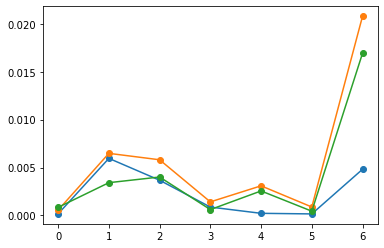

In [13]:
plt.plot( abs(np.array(quantities_pa)-np.array(quantities_in)), '-o' )
